# Analyse Exploratoire – Silent Surge

Ce notebook a pour objectif d’explorer les données de ventes issues de 3 types de commerces :
- Pizzeria
- Boucherie
- Épicerie

Nous allons identifier les tendances de vente par saison, zone, produit et période horaire.


 📊 Analyse saisonnière / commerce

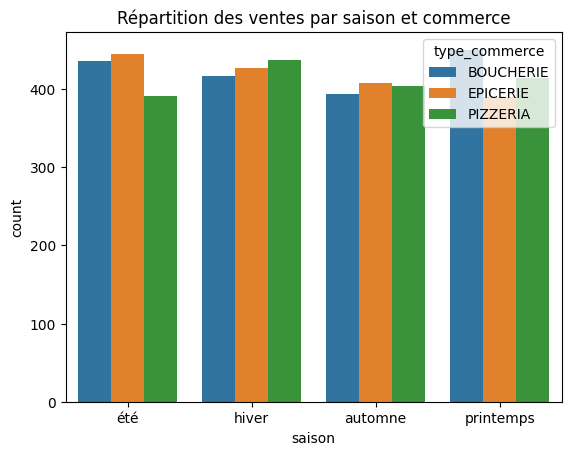

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_all, x='saison', hue='type_commerce')
plt.title("Répartition des ventes par saison et commerce")
plt.show()


🍕 Top produits par saison & commerce 

In [11]:
df_all[(df_all['type_commerce'] == 'PIZZERIA') & (df_all['saison'] == 'hiver')].groupby('produit')['quantite'].sum().sort_values(ascending=False).head()


produit
Moelleux choco    172
Ice Tea           161
Glace             158
Raclette          144
Tiramisu          135
Name: quantite, dtype: int64

## Conclusion

L’analyse montre des pics de ventes saisonniers :
- Pizza Raclette dominante en hiver
- Merguez populaire en été pour la boucherie
- Forte demande en zone touristique

Cela justifie la construction d’un modèle de prédiction dans la suite du projet.


In [16]:
# notebooks/eda_silent_surge.ipynb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# === CONFIGURATION DES CHEMINS === 
PROJET_ROOT = Path(r"C:\Users\Sajed\Desktop\SilentSurgeFinal")  # Chemin ABSOLU
DATA_DIR = PROJET_ROOT / "data"

# === CHARGEMENT DES DONNÉES (VERSION BLINDÉE) ===
def load_commerce_data():
    """Charge TOUS les fichiers CSV avec vérification rigoureuse"""
    fichiers = {
        "PIZZERIA": DATA_DIR / "ventes_pizzeria.csv",
        "BOUCHERIE": DATA_DIR / "ventes_boucherie.csv",
        "EPICERIE": DATA_DIR / "ventes_epicerie.csv"
    }
    
    # Vérification explosive des fichiers
    for commerce, path in fichiers.items():
        if not path.exists():
            raise FileNotFoundError(f"ERREUR CRITIQUE : {path.name} introuvable dans {DATA_DIR}")

    # Chargement effectif
    dfs = []
    for commerce, path in fichiers.items():
        df = pd.read_csv(path)
        df["type_commerce"] = commerce  # Ajout de la colonne type
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

# === EXÉCUTION PRINCIPALE ===
try:
    print(f"🔍 Vérification du dossier data : {list(DATA_DIR.glob('*.csv'))}")
    df = load_commerce_data()
    print(f"✅ Données chargées : {df.shape} lignes")
    
    # Aperçu rapide
    display(df.head(2))
    display(df['type_commerce'].value_counts())
    
except Exception as e:
    print(f"❌ CATASTROPHE : {str(e)}")
    print(f"Liste réelle des fichiers : {[f.name for f in DATA_DIR.glob('*') if f.is_file()]}")

🔍 Vérification du dossier data : [WindowsPath('C:/Users/Sajed/Desktop/SilentSurgeFinal/data/ventes_boucherie.csv'), WindowsPath('C:/Users/Sajed/Desktop/SilentSurgeFinal/data/ventes_epicerie.csv'), WindowsPath('C:/Users/Sajed/Desktop/SilentSurgeFinal/data/ventes_pizzeria.csv')]
✅ Données chargées : (5009, 14) lignes


,client_id,type_commerce,categorie_produit,produit,zone,saison,mois,jour,heure,quantite,prix_unitaire,cout_unitaire,marge_totale,date_vente
0,PIZZERIA,PIZZERIA,Boissons,Ice Tea,Zone touristique bord de mer,hiver,1,4,20,3,20.44,13.88,19.68,2023-01-04
1,PIZZERIA,PIZZERIA,Desserts,Glace,Zone montagne,été,7,5,17,2,6.02,2.58,6.88,2023-07-05


type_commerce
BOUCHERIE    1695
EPICERIE     1668
PIZZERIA     1646
Name: count, dtype: int64

In [20]:
# ANALYSE DES PERFORMANCES CLÉS
def analyse_cles(df):
    # 1. Top 3 produits par marge
    top_marge = df.groupby(['type_commerce', 'produit'])['marge_totale'] \
                .sum() \
                .groupby('type_commerce', group_keys=False) \
                .nlargest(3)
    
    # 2. Heures d'or par commerce
    heures_peak = df.groupby(['type_commerce', 'heure'])['quantite'] \
                  .sum() \
                  .groupby('type_commerce', group_keys=False) \
                  .nlargest(3)
    
    # 3. Zones stratégiques
    zones_strat = df.groupby(['type_commerce', 'zone'])['marge_totale'] \
                  .mean() \
                  .groupby('type_commerce', group_keys=False) \
                  .nlargest(2)
    
    return {
        'TOP_MARGE': top_marge,
        'HEURES_PEAK': heures_peak,
        'ZONES_STRAT': zones_strat
    }

results = analyse_cles(df)
print("🔥 TOP 3 PRODUITS PAR MARGE 🔥")
display(results['TOP_MARGE'])

🔥 TOP 3 PRODUITS PAR MARGE 🔥


type_commerce  produit        
BOUCHERIE      Merguez            5341.89
               Brochettes         5206.56
               Blanc de poulet    3025.05
EPICERIE       Petit Beurre       3306.03
               Curly              3076.21
               Chips              2905.59
PIZZERIA       Eau                3574.41
               Moelleux choco     3379.07
               Coca               3023.49
Name: marge_totale, dtype: float64

In [17]:
# EXPORT EXCEL AUTOMATISÉ
with pd.ExcelWriter('analyse_strategique.xlsx') as writer:
    df.to_excel(writer, sheet_name='Données Brutes', index=False)
    for name, result in results.items():
        result.to_excel(writer, sheet_name=name)
print("📊 Fichier Excel généré : analyse_strategique.xlsx")

NameError: name 'results' is not defined

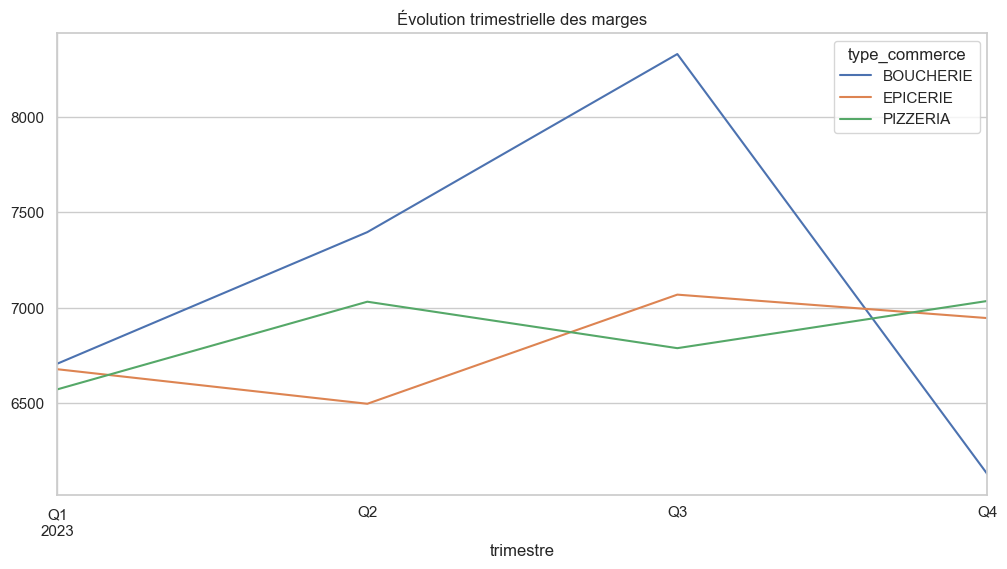

In [22]:
# ANALYSE TEMPORELLE (si colonne 'date_vente' existe)
if 'date_vente' in df.columns:
    df['date'] = pd.to_datetime(df['date_vente'])
    df['trimestre'] = df['date'].dt.to_period('Q')
    
    trends = df.groupby(['type_commerce', 'trimestre'])['marge_totale'] \
             .sum() \
             .unstack('type_commerce') \
             .plot(kind='line', title='Évolution trimestrielle des marges')
    plt.show()

gooooooooooooooooooooooo

# 🍕🥩🛒 EDA SILENT SURGE   
*UF SPE Data & IA - Projet Personnel*

In [5]:
# 1. INSTALLATION DES DEPENDANCES
import sys
!{sys.executable} -m pip install numpy pandas matplotlib seaborn openpyxl --quiet

In [6]:
# 2. IMPORTS SECURISES
try:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from pathlib import Path
    print("✅ Modules importés avec succès")
except ImportError as e:
    print(f"❌ Erreur d'import : {e}")
    print("Solution : lancez 'pip install numpy pandas matplotlib seaborn openpyxl'")

✅ Modules importés avec succès


In [7]:
# 3. CHARGEMENT DES DONNEES (version robuste)
DATA_PATH = Path(r"C:\Users\Sajed\Desktop\SilentSurgeFinal\data")

try:
    dfs = []
    for boutique in ["boucherie", "epicerie", "pizzeria"]:
        file_path = DATA_PATH / f"ventes_{boutique}.csv"
        df = pd.read_csv(file_path).assign(type_commerce=boutique.upper())
        dfs.append(df)
    
    df_all = pd.concat(dfs, ignore_index=True)
    print(f"✅ Données chargées : {len(df_all)} lignes")
    
except Exception as e:
    print(f"❌ Erreur de chargement : {e}")
    print("Fichiers disponibles :")
    print([f.name for f in DATA_PATH.glob("*.csv")])

✅ Données chargées : 5009 lignes


In [8]:
# 4. ANALYSE EXPLORATOIRE (exemple)
if 'df_all' in locals():
    print("\n🔍 Aperçu des données :")
    display(df_all.head(3))
    
    print("\n📊 Statistiques :")
    display(df_all.describe(include='all').round(2))
else:
    print("Impossible de continuer : données non chargées")


🔍 Aperçu des données :


,client_id,type_commerce,categorie_produit,produit,zone,saison,mois,jour,heure,quantite,prix_unitaire,cout_unitaire,marge_totale,date_vente
0,BOUCHERIE,BOUCHERIE,Volaille,Blanc de poulet,Zone résidentielle,été,6,22,9,2,3.68,1.61,4.14,2023-06-22
1,BOUCHERIE,BOUCHERIE,Préparés,Brochettes,Zone urbaine,été,8,24,16,3,4.43,3.41,3.06,2023-08-24
2,BOUCHERIE,BOUCHERIE,Préparés,Merguez,Zone touristique bord de mer,hiver,1,29,11,4,20.81,15.03,23.12,2023-01-29



📊 Statistiques :


,client_id,type_commerce,categorie_produit,produit,zone,saison,mois,jour,heure,quantite,prix_unitaire,cout_unitaire,marge_totale,date_vente
count,5009,5009,5009,5009,5009,5009,5009.00,5009.00,5009.00,5009.00,5009.00,5009.00,5009.00,5009
unique,3,3,11,38,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,365
top,BOUCHERIE,BOUCHERIE,Boissons,Brochettes,Zone rurale,hiver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-03
freq,1695,1695,905,296,1056,1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.49,15.79,15.03,3.15,13.29,7.96,16.60,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,3.46,8.70,4.31,1.85,6.78,4.44,15.09,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,8.00,0.00,1.50,0.62,0.00,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,3.00,8.00,11.00,2.00,7.36,4.20,5.67,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,7.00,16.00,15.00,3.00,13.30,7.60,12.10,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,9.00,23.00,19.00,4.00,19.21,11.19,23.04,NaN


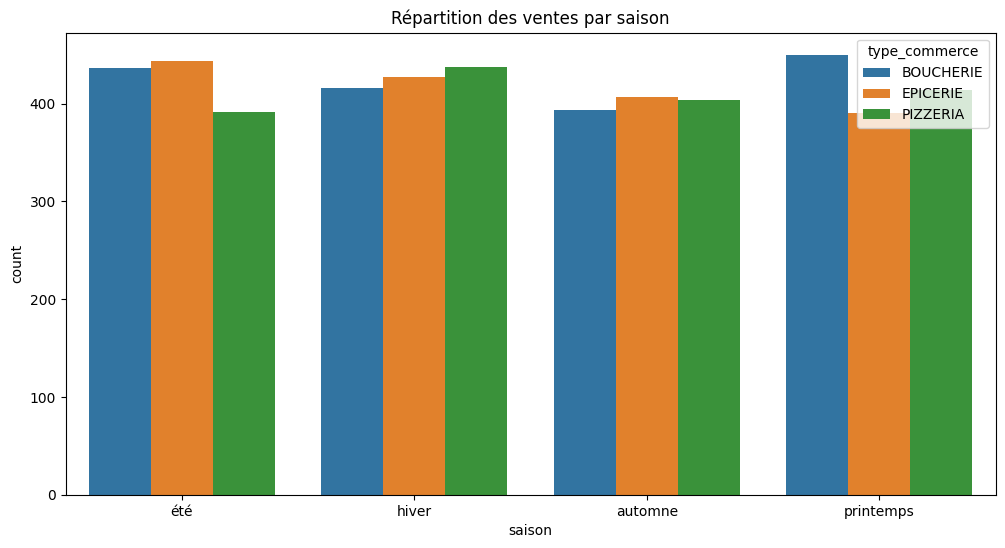

In [9]:
# 5. VISUALISATION CLE
if 'df_all' in locals():
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_all, x='saison', hue='type_commerce')
    plt.title("Répartition des ventes par saison")
    plt.show()
